In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

In [32]:
def W( x, y, z, h ):
	"""
    Gausssian Smoothing kernel (3D)
	x     is a vector/matrix of x positions
	y     is a vector/matrix of y positions
	z     is a vector/matrix of z positions
	h     is the smoothing length
	w     is the evaluated smoothing function
	"""
	
	r = np.sqrt(x**2 + y**2 + z**2)
	
	w = (1.0 / (h*np.sqrt(np.pi)))**3 * np.exp( -r**2 / h**2)
	
	return w
	
	
def gradW( x, y, z, h ):
	"""
	Gradient of the Gausssian Smoothing kernel (3D)
	x     is a vector/matrix of x positions
	y     is a vector/matrix of y positions
	z     is a vector/matrix of z positions
	h     is the smoothing length
	wx, wy, wz     is the evaluated gradient
	"""
	
	r = np.sqrt(x**2 + y**2 + z**2)
	
	n = -2 * np.exp( -r**2 / h**2) / h**5 / (np.pi)**(3/2)
	wx = n * x
	wy = n * y
	wz = n * z
	
	return wx, wy, wz
	
	
def getPairwiseSeparations( ri, rj ):
	"""
	Get pairwise desprations between 2 sets of coordinates
	ri    is an M x 3 matrix of positions
	rj    is an N x 3 matrix of positions
	dx, dy, dz   are M x N matrices of separations
	"""
	
	M = ri.shape[0]
	N = rj.shape[0]
	
	# positions ri = (x,y,z)
	rix = ri[:,0].reshape((M,1))
	riy = ri[:,1].reshape((M,1))
	riz = ri[:,2].reshape((M,1))
	
	# other set of points positions rj = (x,y,z)
	rjx = rj[:,0].reshape((N,1))
	rjy = rj[:,1].reshape((N,1))
	rjz = rj[:,2].reshape((N,1))
	
	# matrices that store all pairwise particle separations: r_i - r_j
	dx = rix - rjx.T
	dy = riy - rjy.T
	dz = riz - rjz.T
	
	return dx, dy, dz
	

def getDensity( r, pos, m, h ):
	"""
	Get Density at sampling loctions from SPH particle distribution
	r     is an M x 3 matrix of sampling locations
	pos   is an N x 3 matrix of SPH particle positions
	m     is the particle mass
	h     is the smoothing length
	rho   is M x 1 vector of densities
	"""
	
	M = r.shape[0]
	
	dx, dy, dz = getPairwiseSeparations( r, pos );
	
	rho = np.sum( m * W(dx, dy, dz, h), 1 ).reshape((M,1))
	
	return rho
	
	
def getPressure(rho, k, n):
	"""
	Equation of State
	rho   vector of densities
	k     equation of state constant
	n     polytropic index
	P     pressure
	"""
	
	P = k * rho**(1+1/n)
	
	return P
	

def getAcc( pos, vel, m, h, k, n, lmbda, nu ):
	"""
	Calculate the acceleration on each SPH particle
	pos   is an N x 3 matrix of positions
	vel   is an N x 3 matrix of velocities
	m     is the particle mass
	h     is the smoothing length
	k     equation of state constant
	n     polytropic index
	lmbda external force constant
	nu    viscosity
	a     is N x 3 matrix of accelerations
	"""
	
	N = pos.shape[0]
	
	# Calculate densities at the position of the particles
	rho = getDensity( pos, pos, m, h )
	
	# Get the pressures
	P = getPressure(rho, k, n)
	
	# Get pairwise distances and gradients
	dx, dy, dz = getPairwiseSeparations( pos, pos )
	dWx, dWy, dWz = gradW( dx, dy, dz, h )
	
	# Add Pressure contribution to accelerations
	ax = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWx, 1).reshape((N,1))
	ay = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWy, 1).reshape((N,1))
	az = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWz, 1).reshape((N,1))
	
	# pack together the acceleration components
	a = np.hstack((ax,ay,az))
	
	# Add external potential force
	a -= lmbda * pos
	
	# Add viscosity
	a -= nu * vel
	
	return a
	

def main():
	""" SPH simulation """
	
	# Simulation parameters
	N         = 400    # Number of particles
	t         = 0      # current time of the simulation
	tEnd      = 12     # time at which simulation ends
	dt        = 0.04   # timestep
	M         = 2      # star mass
	R         = 0.75   # star radius
	h         = 0.1    # smoothing length
	k         = 0.1    # equation of state constant
	n         = 1      # polytropic index
	nu        = 1      # damping
	plotRealTime = True # switch on for plotting as the simulation goes along
	
	# Generate Initial Conditions
	np.random.seed(42)            # set the random number generator seed
	
	lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2  # ~ 2.01
	m     = M/N                    # single particle mass
	pos   = np.random.randn(N,3)   # randomly selected positions and velocities
	vel   = np.zeros(pos.shape)
	
	# calculate initial gravitational accelerations
	acc = getAcc( pos, vel, m, h, k, n, lmbda, nu )
	
	# number of timesteps
	Nt = int(np.ceil(tEnd/dt))
	
	# prep figure
	fig = plt.figure(figsize=(4,5), dpi=80)
	grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
	ax1 = plt.subplot(grid[0:2,0])
	ax2 = plt.subplot(grid[2,0])
	rr = np.zeros((100,3))
	rlin = np.linspace(0,1,100)
	rr[:,0] =rlin
	rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)
	
	# Simulation Main Loop
	for i in range(Nt):
		# (1/2) kick
		vel += acc * dt/2
		
		# drift
		pos += vel * dt
		
		# update accelerations
		acc = getAcc( pos, vel, m, h, k, n, lmbda, nu )
		
		# (1/2) kick
		vel += acc * dt/2
		
		# update time
		t += dt
		
		# get density for plotting
		rho = getDensity( pos, pos, m, h )
		
		# plot in real time
		if plotRealTime or (i == Nt-1):
			plt.sca(ax1)
			plt.cla()
			cval = np.minimum((rho-3)/3,1).flatten()
			plt.scatter(pos[:,0],pos[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.5)
			ax1.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
			ax1.set_aspect('equal', 'box')
			ax1.set_xticks([-1,0,1])
			ax1.set_yticks([-1,0,1])
			ax1.set_facecolor('black')
			ax1.set_facecolor((.1,.1,.1))
			
			plt.sca(ax2)
			plt.cla()
			ax2.set(xlim=(0, 1), ylim=(0, 3))
			ax2.set_aspect(0.1)
			plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
			rho_radial = getDensity( rr, pos, m, h )
			plt.plot(rlin, rho_radial, color='blue')
			plt.pause(0.001)
	    
	
	
	# add labels/legend
	plt.sca(ax2)
	plt.xlabel('radius')
	plt.ylabel('density')
	
	# Save figure
	plt.savefig('sph.png',dpi=240)
	plt.show()
	    
	return 0

In [33]:
! python -m cProfile -s cumulative test.py

[[1.17347539]
 [0.89793561]
 [0.89849749]
 [0.89846611]
 [0.89793571]
 [0.91526194]
 [0.90257091]
 [0.89793593]
 [0.89814229]
 [1.07461324]
 [1.26578266]
 [0.89793608]
 [0.89857724]
 [1.02198791]
 [0.90413998]
 [0.94432872]
 [0.89793561]
 [0.89874589]
 [0.89793561]
 [0.92571631]
 [0.89887717]
 [0.89793573]
 [1.13517022]
 [0.89793561]
 [0.90256315]
 [0.96275294]
 [1.07560105]
 [0.89793562]
 [0.99539301]
 [0.89915105]
 [0.89861202]
 [1.54430533]
 [0.89841123]
 [0.9162576 ]
 [0.89805225]
 [0.89793592]
 [0.8979361 ]
 [0.89793561]
 [0.90481794]
 [0.89793561]
 [0.89793745]
 [0.89793561]
 [0.89811275]
 [0.89793571]
 [0.89949434]
 [0.89793561]
 [0.89796881]
 [0.89793561]
 [0.90038161]
 [0.95873392]
 [1.47951933]
 [1.48085629]
 [0.89793561]
 [1.02372908]
 [0.89793565]
 [0.90720631]
 [0.89793561]
 [1.02560688]
 [1.28861538]
 [0.89793561]
 [0.89793561]
 [1.19044086]
 [0.89915315]
 [0.89793561]
 [0.90369718]
 [1.01207084]
 [0.92162704]
 [1.32338946]
 [0.89793581]
 [0.89793561]
 [1.286612  ]
 [0.91

# Results
Most time consuming methods in sph.py: 
1. getAcc: Cumulative Time: 1.329 seconds in the profiling file
2. getDensity: Cumulative Time: 1.221 seconds in the profiling file
3. W: Cumulative Time: 0.725 seconds in the profiling file
4. gradW: Cumulative Time: 0.411 seconds in the profiling file
5. getPairwiseSeparations: 0.520 seconds in the profiling file

In [34]:
! python -m cProfile -o profile.stats test.py

[[1.17347539]
 [0.89793561]
 [0.89849749]
 [0.89846611]
 [0.89793571]
 [0.91526194]
 [0.90257091]
 [0.89793593]
 [0.89814229]
 [1.07461324]
 [1.26578266]
 [0.89793608]
 [0.89857724]
 [1.02198791]
 [0.90413998]
 [0.94432872]
 [0.89793561]
 [0.89874589]
 [0.89793561]
 [0.92571631]
 [0.89887717]
 [0.89793573]
 [1.13517022]
 [0.89793561]
 [0.90256315]
 [0.96275294]
 [1.07560105]
 [0.89793562]
 [0.99539301]
 [0.89915105]
 [0.89861202]
 [1.54430533]
 [0.89841123]
 [0.9162576 ]
 [0.89805225]
 [0.89793592]
 [0.8979361 ]
 [0.89793561]
 [0.90481794]
 [0.89793561]
 [0.89793745]
 [0.89793561]
 [0.89811275]
 [0.89793571]
 [0.89949434]
 [0.89793561]
 [0.89796881]
 [0.89793561]
 [0.90038161]
 [0.95873392]
 [1.47951933]
 [1.48085629]
 [0.89793561]
 [1.02372908]
 [0.89793565]
 [0.90720631]
 [0.89793561]
 [1.02560688]
 [1.28861538]
 [0.89793561]
 [0.89793561]
 [1.19044086]
 [0.89915315]
 [0.89793561]
 [0.90369718]
 [1.01207084]
 [0.92162704]
 [1.32338946]
 [0.89793581]
 [0.89793561]
 [1.286612  ]
 [0.91

In [ ]:
! python -m snakeviz profile.stats --server

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fcarlottaholzle%2FDesktop%2FKTH%20Assignments%2FComputational-Astrophysics%2Fprofile.stats
^C

Bye!


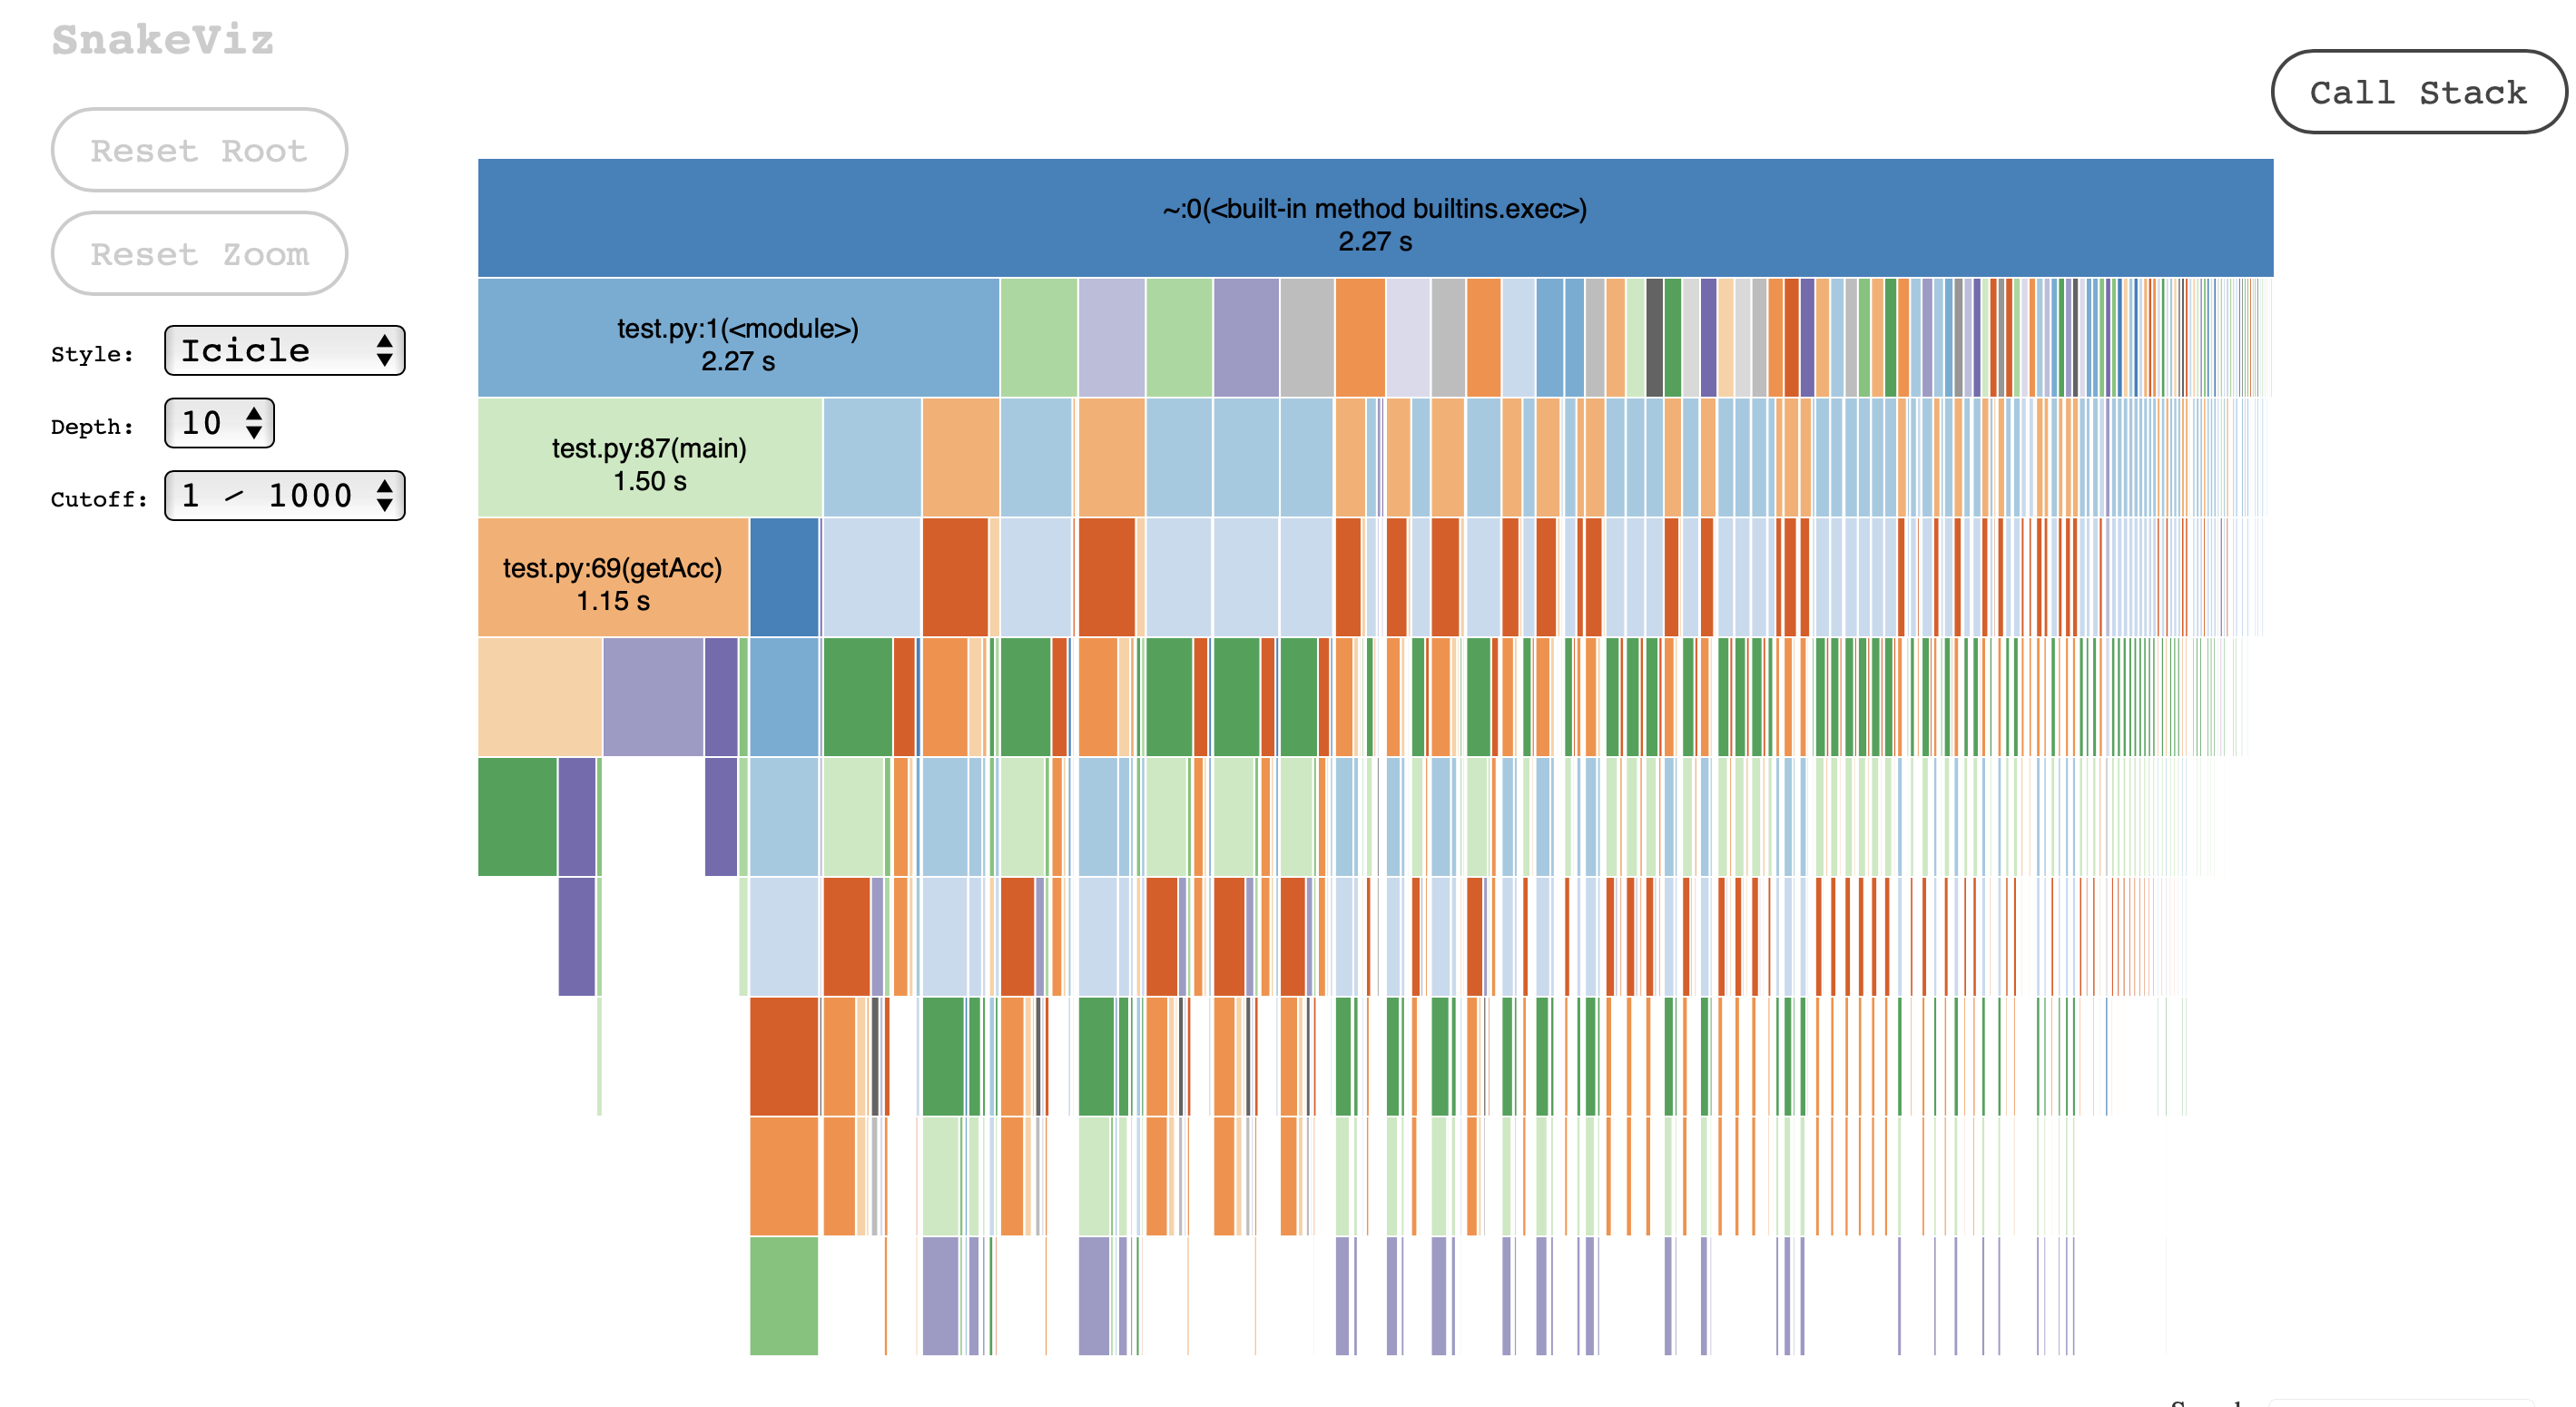

## getAcc profiling 


In [11]:
! python -m kernprof -l test.py 

Wrote profile results to test.py.lprof
Inspect results with:
python -m line_profiler -rmt "test.py.lprof"


In [12]:
! python -m line_profiler -rmt "test.py.lprof"

Timer unit: 1e-06 s

Total time: 3.94959 s
File: test.py
Function: getAcc at line 112

Line #      Hits         Time  Per Hit   % Time  Line Contents
   112                                           @profile 
   113                                           def getAcc(pos, vel, m, h, k, n, lmbda, nu):
   114                                               """
   115                                               Calculate the acceleration on each SPH particle
   116                                               """
   117       301        284.0      0.9      0.0      N = pos.shape[0]
   118                                               #rho = getDensity(pos, pos, m, h, optimizedW)
   119       301    3088833.0  10261.9     78.2      rho = optimizedGetDensity(pos, pos, m, h)
   120       301       1079.0      3.6      0.0      P = getPressure(rho, k, n)
   121       301     166588.0    553.4      4.2      dx, dy, dz = getPairwiseSeparations(pos, pos)
   122       301     447033.0   1485.2 

The most expensive operation is the density calculation (getDensity), it consums 41.5% of the time.	The inefficiency arises from the pairwise computations involved in getPairwiseSeparations and kernel evaluations. 
The kernel gradient calculation (gradW) is with 32.8% of the total time the second most time consuming operation. The three np.sum calls contribute about 15% of the time. As these calculations are repetitive they should be streamlined.

Line profiling of old getDensity() method 

In [8]:
! python -m kernprof -l test.py 

Wrote profile results to test.py.lprof
Inspect results with:
python -m line_profiler -rmt "test.py.lprof"


In [9]:
! python -m line_profiler -rmt "test.py.lprof"

Timer unit: 1e-06 s

Total time: 0.459439 s
File: test.py
Function: getDensity at line 50

Line #      Hits         Time  Per Hit   % Time  Line Contents
    50                                           @profile
    51                                           def getDensity(r, pos, m, h):
    52                                               """
    53                                               Get Density at sampling locations from SPH particle distribution
    54                                               """
    55       301        185.0      0.6      0.0      M = r.shape[0]
    56       301     136022.0    451.9     29.6      dx, dy, dz = getPairwiseSeparations(r, pos)
    57       301     323124.0   1073.5     70.3      rho = np.sum(m * W(dx, dy, dz, h), 1).reshape((M, 1))
    58       301        108.0      0.4      0.0      return rho

  0.46 seconds - test.py:50 - getDensity


Adaptions to getDensity(): 

1. Limit Pairwise Computations: Instead of computing pairwise separations for all  N  particles, compute them only for neighbors within the smoothing length h. 
2. scipy.spatial.cKDTree: Builds a spatial index of the particle positions for efficient neighbor queries, thus reducing the need to compute all pairwise distances.
3. The kernel (W) is evaluated only for neighbors, significantly reducing the number of expensive exponential function calls.

Line profiling of rewritten getDensity() method

In [35]:
! pytest -v test_w.py

============================= test session starts ==============================
platform darwin -- Python 3.12.7, pytest-7.4.4, pluggy-1.0.0 -- /opt/anaconda3/bin/python
cachedir: .pytest_cache
rootdir: /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics
plugins: anyio-4.2.0
collected 1 item                                                               

test_w.py::testW PASSED                                                  [100%]

============================== 1 passed in 0.57s ===============================


In [36]:
! pytest -v test_get_density.py

============================= test session starts ==============================
platform darwin -- Python 3.12.7, pytest-7.4.4, pluggy-1.0.0 -- /opt/anaconda3/bin/python
cachedir: .pytest_cache
rootdir: /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics
plugins: anyio-4.2.0
collected 1 item                                                               

test_get_density.py::test_get_density PASSED                             [100%]

============================== 1 passed in 0.43s ===============================


In [13]:
! python -m kernprof -l test.py 

Wrote profile results to test.py.lprof
Inspect results with:
python -m line_profiler -rmt "test.py.lprof"


In [14]:
! python -m line_profiler -rmt "test.py.lprof"

Timer unit: 1e-06 s

Total time: 0 s
File: test.py
Function: getDensity at line 53

Line #      Hits         Time  Per Hit   % Time  Line Contents
    53                                           @profile
    54                                           def getDensity(r, pos, m, h, kernel = W):
    55                                               """
    56                                               Get Density at sampling locations from SPH particle distribution
    57                                               """
    58                                               M = r.shape[0]
    59                                               dx, dy, dz = getPairwiseSeparations(r, pos)
    60                                               # rho = np.sum(m * W(dx, dy, dz, h), 1).reshape((M, 1))
    61                                               rho = np.sum(m * kernel(dx, dy, dz, h), 1).reshape((M, 1))
    62                                               return rho

  0.00 seconds - test

getPaiwiseSeperations() 


In [64]:
! pytest -v test_getPairwiseSeperations.py

============================= test session starts ==============================
platform darwin -- Python 3.12.7, pytest-7.4.4, pluggy-1.0.0 -- /opt/anaconda3/bin/python
cachedir: .pytest_cache
rootdir: /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics
plugins: anyio-4.2.0
collected 3 items                                                              

test_getPairwiseSeperations.py::test_dx PASSED                           [ 33%]
test_getPairwiseSeperations.py::test_dy PASSED                           [ 66%]
test_getPairwiseSeperations.py::test_dz PASSED                           [100%]

============================== 3 passed in 0.71s ===============================


In [60]:
! python -m kernprof -l test.py 

Wrote profile results to test.py.lprof
Inspect results with:
python -m line_profiler -rmt "test.py.lprof"


In [61]:
! python -m line_profiler -rmt "test.py.lprof"

Timer unit: 1e-06 s

Total time: 1.02568 s
File: test.py
Function: getAcc at line 260

Line #      Hits         Time  Per Hit   % Time  Line Contents
   260                                           @profile 
   261                                           def getAcc(pos, vel, m, h, k, n, lmbda, nu):
   262                                               """
   263                                               Calculate the acceleration on each SPH particle
   264                                               """
   265       301        175.0      0.6      0.0      N = pos.shape[0]
   266       301     284170.0    944.1     27.7      rho = getDensity(pos, pos, m, h, optimizedW)
   267                                               #rho = optimizedGetDensity(pos, pos, m, h)
   268       301       2004.0      6.7      0.2      P = getPressure(rho, k, n)
   269       301     145124.0    482.1     14.1      dx, dy, dz = getPairwiseSeparations(pos, pos)
   270       301     379236.0   1259.9 